In [340]:
import shapefile
import glob
import rasterio.mask
import rasterio.warp
import shapely.geometry
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [341]:
from enum import Enum

class ShapeClass(Enum):
    CACAO = 1
    COFFEE = 2
    COMPLEX_OIL = 3
    NATIVEVEGE = 4
    OIL_PALM = 5
    RUBBER = 6
    UNKNOWN = 7
    SEASONAL = 8
    URBAN = 9
    WATER = 10
    OTHER_TREE = 11
    OTHER_NO_TREE = 12
    NATIVE_NO_TREE = 13
    WATER_OTHER = 14
    PEPPER = 15
    CASSAVA = 16
    TEA = 17
    RICE = 18
    BANANA_JUNG = 19
    BABY_PALM = 20
    CUT_OFF_REGROW = 21
    NATURAL_WETLAND = 22
    INTERCROP = 23
    DECIDUOUS_FOREST = 24
    STICK_PEPPER = 25
    FLOODED_PLANTATION = 26
    PINE_TREES = 27
    COCONUT = 28
    BAMBOO = 29
    SAVANA = 30
    MANGO = 31
    OTHER_FRUIT_TREE_CROP = 32
    WATER_MINE = 33

In [342]:
def polygon_nb_px_around_coordinates(coordinate, n, dataset):
    lat = coordinate[0]
    lon = coordinate[1]

    row, col = dataset.index(lat, lon)

    min_coord = rasterio.transform.xy(dataset.transform, row - n, col - n, offset='ul')
    max_coord = rasterio.transform.xy(dataset.transform, row + n, col + n, offset='lr')

    return shapely.geometry.box(min_coord[0], min_coord[1], max_coord[0], max_coord[1])

In [343]:
# Open shapefiles
shapefile_root_path = "labels/"
shapefiles_paths = glob.glob(shapefile_root_path + "**/*.shp")

In [344]:
# Create a dictionary which will contain all
# points classified in the opened shapefiles
# with their coordinates lat-lon
classes_points_coordinates = {}

# Initialize the dictionary
for i in range(1, 34):
    classes_points_coordinates[i] = []

# Add each points coordinate
# in its corresponding class
for path in shapefiles_paths:
    sf = shapefile.Reader(path)

    for shape_record in sf.shapeRecords():
        if shape_record.record.Class <= 33:
            current_list = classes_points_coordinates.get(shape_record.record.Class)
            current_list.append(shape_record.shape.points[0])
            classes_points_coordinates[shape_record.record.Class] = current_list

In [345]:
def write_raster_to_disk(raster, metadata, transform, crs, filename):
    metadata.update({
        "driver": "GTiff",
        "height": raster.shape[1],
        "width": raster.shape[2],
        "transform": transform,
        "crs": crs
    })

    # Write merged raster to disk
    with rasterio.open('./tiles/' + filename, "w", **metadata) as dest:
        dest.write(raster)

In [346]:
def raster_n_px_around_tagged_point(coordinates, nb_pixel_around, initial_raster):
    polygon = polygon_nb_px_around_coordinates(coordinates, nb_pixel_around, initial_raster)
    return rasterio.mask.mask(initial_raster, shapes=[polygon], crop=True, nodata=float('nan'))

In [347]:
NB_PIXEL_AROUND_POINT = 4

In [348]:
def tagged_points_bands_values(point_class, initial_raster):
    values = []
        
    for coordinates in classes_points_coordinates[point_class]:
        out_img, out_transform = raster_n_px_around_tagged_point(coordinates, NB_PIXEL_AROUND_POINT, initial_raster)
        
        # Don't add data if all values are 'NaN'
        if not np.isnan(out_img).all():
            # Add median values of each band (excepted cirrus, tirs1, tirs2) while filtering nodata values
            values.append([np.nanmedian(out_img[i]) for i in range(0,8)])
     
    return np.array(values)

In [349]:
def write_raster_around_tagged_points(point_class, initial_raster):
    i = 0
    for coordinates in classes_points_coordinates[point_class]:
        out_img, out_transform = raster_n_px_around_tagged_point(coordinates, NB_PIXEL_AROUND_POINT, initial_raster)
        
        write_raster_to_disk(
            out_img,
            initial_raster.meta.copy(),
            out_transform,
            initial_raster.crs.to_proj4(),
            filename = str(ShapeClass(point_class).name) + '_' + str(i) + '.tif'
        )
        
        i += 1

In [350]:
def normalize_dataframe(dataframe, columns):
    scaler = preprocessing.MinMaxScaler() 
    scaled_values = scaler.fit_transform(dataframe[columns]) 
    dataframe[columns] = scaled_values
    return dataframe

In [351]:
def draw_bands_boxplots(df, hue):
    g = sns.FacetGrid(df, col="bands", col_wrap=4)
    g.map_dataframe(sns.boxplot, x="bands", y="value", hue=hue)
    g.add_legend()
    g.set_titles(col_template="{col_name}")
    g.set(xticklabels=[])

In [352]:
def coffee_comparison_to_other_entities(raster_path):
    # Open raster
    initial_raster = rasterio.open(raster_path) 
    
    # Get values for each label we are interested in
    coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster)
    pepper_values = tagged_points_bands_values(ShapeClass.PEPPER.value, initial_raster)
    nativevege_values = tagged_points_bands_values(ShapeClass.NATIVEVEGE.value, initial_raster)
    tea_values = tagged_points_bands_values(ShapeClass.TEA.value, initial_raster)
    urban_values = tagged_points_bands_values(ShapeClass.URBAN.value, initial_raster)
    water_values = tagged_points_bands_values(ShapeClass.WATER.value, initial_raster)
    
    # Create dataframes from those values
    columns = ['coastal aerosol', 'blue', 'green', 'red', 'nir', 'swir 1', 'swir 2', 'panchromatic']
    coffee_df = pandas.DataFrame(coffee_values, columns=columns).assign(label="Coffee")
    pepper_df = pandas.DataFrame(pepper_values, columns=columns).assign(label="Pepper")
    nativevege_df = pandas.DataFrame(nativevege_values, columns=columns).assign(label="Native Vegetation")
    tea_df = pandas.DataFrame(tea_values, columns=columns).assign(label="Tea")
    urban_df = pandas.DataFrame(urban_values, columns=columns).assign(label="Urban")
    water_df = pandas.DataFrame(water_values, columns=columns).assign(label="Water")

    # Concatenate all those dataframe into one
    concat_df = pandas.concat([coffee_df, pepper_df, nativevege_df, tea_df, urban_df, water_df])
    
    normalize_dataframe(concat_df, columns)
    
    df = pandas.melt(concat_df, id_vars=['label'], var_name=['bands'])
    
    draw_bands_boxplots(df, "label")
    
    # Draw Scatter plot
    # sns.pairplot(concat_df, hue="label", height=2.5, palette="Set3")

#  Coffee comparison to other entities

Il semble plus facile de distinguer le café des autres labels pendant la saison sèche. En effet, en regardant les différentes boîtes à moustache, on remarque qu'il est plus facile de différencer les labels avec les canaux _coastal aerosol_, _blue_, _green_, _red_ et _nir_ en saison sèche qu'en saison humide.

On remarque aussi que le café prend des valeurs proches du poivre, du thé et de l'eau. Toutefois, le café s'écarte un peu de poivre avec le canal _red_ et du thé et de l'eau avec le canal _nir_ même s'il reste encore un assez grand chevauchement entre leurs données.  

## Dry Season (2016 - 2018) 

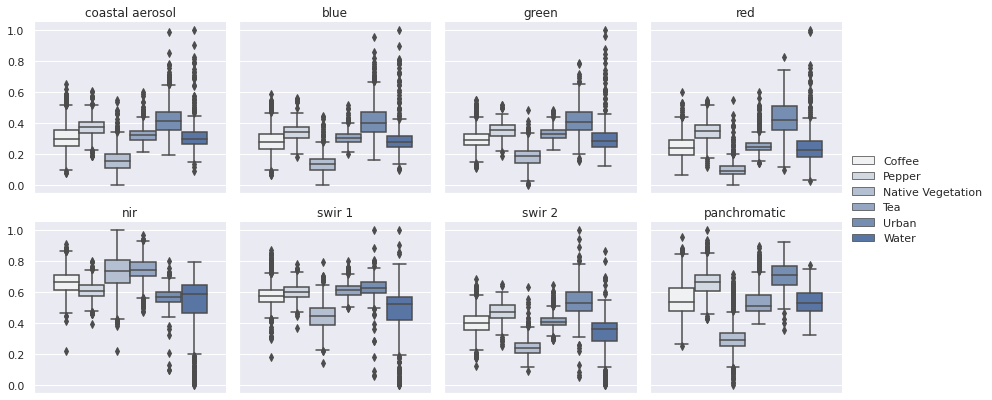

In [353]:
coffee_comparison_to_other_entities('./Vietnam_2016-2018_dry_season/merged.tif')

## Wet Season (2016 - 2018)

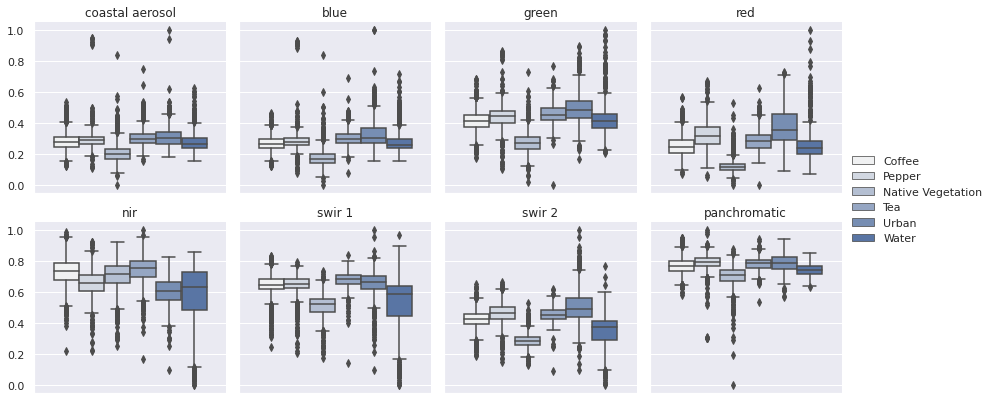

In [354]:
coffee_comparison_to_other_entities('./Vietnam_2016-2018_wet_season/merged.tif')

# Coffee comparison by season
Au Vietnam, il y a deux saisons : la saison sèche et la saison humide. La saison sèche commence en novembre et fini en avril. La saison humide, quant à elle, commence mai et fini en octobre [1].

Si l'on étudie la variabilité des données du café à travers ces deux saisons, on observe que la variabilité est tantôt meilleur en saison sèche et tantôt meilleure en saison humide.

Sur les années 2014 à 2016, la saison humide à moins de variabilité à part pour le canal _nir_ alors que pendant les années 2016 à 2018, la variabilité est plus faible en saison sèche pour tous les canaux sauf _red_, _swir1_, _swir2_, et _panchromatic_.

Pour ce qui est des valeurs médianes, on remarque une net augmentation du canal _nir_, de ~0.43 à ~0.65, en saison humide. Le canal _green_ augmente lui aussi, mais en 2016-2018 plus fortement, passant de ~0.35 à ~0.45 pour les années 2014 à 2016 et ~0.51 en 2016 à 2018.

Tous les canaux ont tendances à légèrement augmenter à part _red_, _panchromatic_ et _swir2_ qui baissent légèrement en saison humide.

[1] https://www.britannica.com/place/Vietnam/Climate, Climate of Vietnam, Britannica

In [355]:
dry_2014_raster_path = './Vietnam_2014-2016_dry_season/merged.tif'
dry_2014_initial_raster = rasterio.open(dry_2014_raster_path) # Open raster
dry_2014_coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, dry_2014_initial_raster)

wet_2014_raster_path = './Vietnam_2014-2016_wet_season/merged.tif'
wet_2014_initial_raster = rasterio.open(wet_2014_raster_path) # Open raster
wet_2014_coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, wet_2014_initial_raster)

dry_2016_raster_path = './Vietnam_2016-2018_dry_season/merged.tif'
dry_2016_initial_raster = rasterio.open(dry_2016_raster_path) # Open raster
dry_2016_coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, dry_2016_initial_raster)

wet_2016_raster_path = './Vietnam_2016-2018_wet_season/merged.tif'
wet_2016_initial_raster = rasterio.open(wet_2016_raster_path) # Open raster
wet_2016_coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, wet_2016_initial_raster)

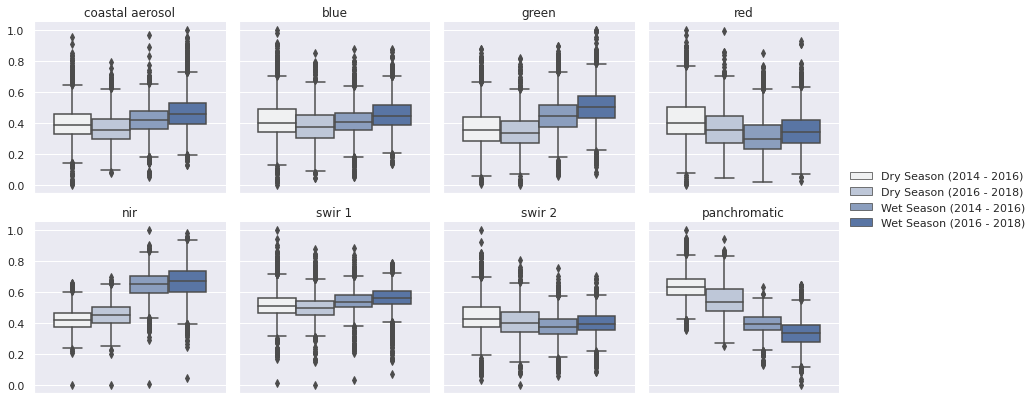

In [356]:
columns = ['coastal aerosol', 'blue', 'green', 'red', 'nir', 'swir 1', 'swir 2', 'panchromatic']
timePeriods = [
    'Dry Season (2014 - 2016)',
    'Dry Season (2016 - 2018)',
    'Wet Season (2014 - 2016)',
    'Wet Season (2016 - 2018)'
]

# Create a dataframe containing the data of each bands
coffee_df_list = []

coffee_df_list.append(pandas.DataFrame(dry_2014_coffee_values, columns=columns).assign(timePeriod=timePeriods[0]))
coffee_df_list.append(pandas.DataFrame(dry_2016_coffee_values, columns=columns).assign(timePeriod=timePeriods[1]))
coffee_df_list.append(pandas.DataFrame(wet_2014_coffee_values, columns=columns).assign(timePeriod=timePeriods[2]))
coffee_df_list.append(pandas.DataFrame(wet_2016_coffee_values, columns=columns).assign(timePeriod=timePeriods[3]))

sns.set(rc={'figure.figsize':(15,12)})

concat_df = pandas.concat([coffee_df_list[0], coffee_df_list[1], coffee_df_list[2], coffee_df_list[3]])

normalize_dataframe(concat_df, columns)

df = pandas.melt(concat_df, id_vars=['timePeriod'], var_name=['bands'])

draw_bands_boxplots(df, "timePeriod")

In [357]:
# Print statistical data pertaining to each time period
for timePeriod in timePeriods:
    print('\n', timePeriod, '\n----------------\n', concat_df.loc[concat_df['timePeriod'] == timePeriod].describe())


 Dry Season (2014 - 2016) 
----------------
        coastal aerosol         blue        green          red          nir  \
count      4114.000000  4114.000000  4114.000000  4114.000000  4114.000000   
mean          0.398606     0.417663     0.365532     0.422664     0.418018   
std           0.104189     0.117785     0.116728     0.138610     0.070874   
min           0.000000     0.000000     0.010860     0.000000     0.002693   
25%           0.333333     0.344743     0.285068     0.329087     0.371553   
50%           0.387387     0.403423     0.352941     0.402383     0.417981   
75%           0.458333     0.488998     0.437104     0.504964     0.463832   
max           0.954955     1.000000     0.876018     1.000000     0.659869   

            swir 1       swir 2  panchromatic  
count  4114.000000  4114.000000   4114.000000  
mean      0.519723     0.441576      0.632618  
std       0.090688     0.106360      0.083230  
min       0.011706     0.031847      0.353535  
25%       0

## Coffee comparison each two months (2014-2020)
Ici, on compare les valeurs des canaux du café deux mois par deux mois en prenant une médiane de toutes les données récoltées entre 2014 à 2020.

On remarque alors quelles sont les périodes qui ont le moins de variabilité et l'évolution des canaux à travers les mois.

### Contexte
Au Vietnam, la récolte du café commence en octobre [1] et prend fin de décembre à janvier [2], [3].

Après la récolte, les arbres à café sont taillés pour laisser plus lumière passer et c'est de janvier à avril où le caféier est fortement arrosé [2].

En février se déroule le Têt, la fête du nouvel an lunaire, et il est possible que la café soit volontairement abondamment arosé pour fleurir pendant Têt. 

[1] http://www.fao.org/3/ap301e/ap301e.pdf, "Diversification by smallholder farmers: Vietnam Robusta Coffee", AGSF, p.9

[2] ibid., p.19

[3] http://amarin.com.vn/coffee-harvest-season, "Harvest Season", AmaRin

### Évolution
C'est à partir de mai que le canal _nir_ augmente significativement, la médiane augmentant de 0.417 à 0.653.

En mars à avril, le canal rouge est au plus haut. En effet la médiane passe à 0.404 alors qu'elle était à 0.324 et qu'elle retombe ensuite à 0.333.

On observe aussi que _panchromatic_ augmente en mars à avril.

Le canal _green_, quant à lui, est à son plus haut en mai à juin et juillet à août.

### Variabilité
Voici les mois qui ont le moins de variabilité pour certains canaux :
- Septembre à octobre : coastal aerosol, blue, green, swir1, swir2, panchromatic
- Novembre à décembre : red 
- Mars à avril : _nir_

Septembre à octobre est la période avec la plus petite variabilité pour toutes les bandes de fréquences sauf _red_ et _nir_.

### Proportion de nuage moyenne
Cette proportion a été calculée à partir du script de téléchargement avec : 

```
merged_image_collections.aggregate_stats('CLOUD_COVER').getInfo()
```

- Janvier à février : 28.71%
- Mars à avril : 23.30%
- Mai à juin : 37.40%
- Juillet à août : 45.11%
- Septembre à octobre : 39.66%
- Novembre à décembre : 38.90%

In [358]:
coffee_values_list = []

raster_path_01 = './Vietnam_01_02/merged.tif'
initial_raster_01 = rasterio.open(raster_path_01) # Open raster
coffee_values_list.append(tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster_01)) 

raster_path_02 = './Vietnam_03_04/merged.tif'
initial_raster_02 = rasterio.open(raster_path_02) # Open raster
coffee_values_list.append(tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster_02))

raster_path_03 = './Vietnam_05_06/merged.tif'
initial_raster_03 = rasterio.open(raster_path_03) # Open raster
coffee_values_list.append(tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster_03))

raster_path_04 = './Vietnam_07_08/merged.tif'
initial_raster_04 = rasterio.open(raster_path_04) # Open raster
coffee_values_list.append(tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster_04))

raster_path_05 = './Vietnam_09_10/merged.tif'
initial_raster_05 = rasterio.open(raster_path_05) # Open raster
coffee_values_list.append(tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster_05))

raster_path_06 = './Vietnam_11_12/merged.tif'
initial_raster_06 = rasterio.open(raster_path_06) # Open raster
coffee_values_list.append(tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster_06))

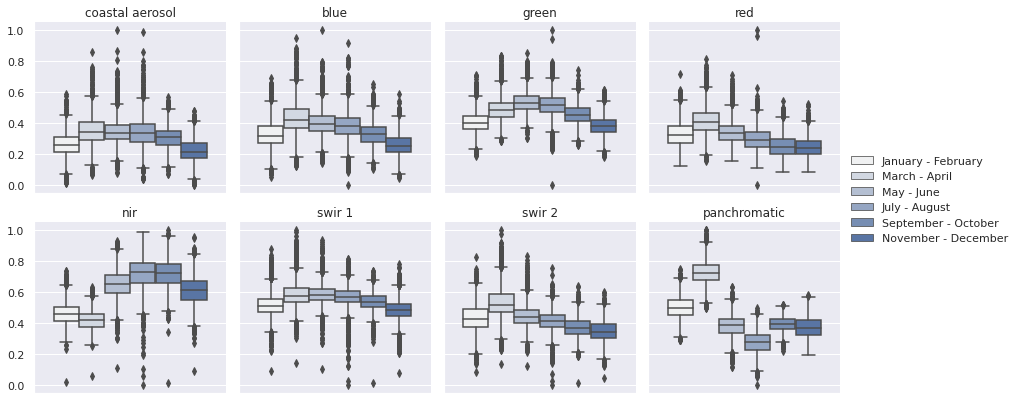

In [359]:
columns = ['coastal aerosol', 'blue', 'green', 'red', 'nir', 'swir 1', 'swir 2', 'panchromatic']

timePeriods = [
    'January - February', 'March - April', 'May - June', 
    'July - August', 'September - October', 'November - December'
]

coffee_df_list = []

for i, timePeriod in enumerate(timePeriods):
    # Create a dataframe containing the data of each bands and
    # add a value indicating the corresponding time period
    coffee_df_list.append(pandas.DataFrame(coffee_values_list[i], columns=columns).assign(timePeriod=timePeriod))

# Set seaborn figures sizes
sns.set(rc={'figure.figsize':(15,12)})

# Concatenate the dataframe of each time periods into one
concat_df = pandas.concat(coffee_df_list)

normalize_dataframe(concat_df, columns)

df = pandas.melt(concat_df, id_vars=['timePeriod'], var_name=['bands'])

draw_bands_boxplots(df, "timePeriod")

In [360]:
# For each band, list standard deviations of each time period
bands_std = {
    band: [
        concat_df.loc[concat_df['timePeriod'] == timePeriod][band].std() for timePeriod in timePeriods
    ] for band in columns
}

# For each band list time period by ascending standard deviations
for band in bands_std:
    std_asc = list(map(lambda arg: (timePeriods[arg], bands_std[band][arg]), np.argsort(np.array(bands_std[band]))))
    
    print('\n', band, ':\n---------------')
    
    for std in std_asc:
        print(std[0], ": ", std[1])


 coastal aerosol :
---------------
September - October :  0.06858603964392869
November - December :  0.06968217120081252
January - February :  0.07229532328583524
May - June :  0.08187344475606481
March - April :  0.0889104406379916
July - August :  0.09259488680165236

 blue :
---------------
September - October :  0.06942638634203674
November - December :  0.07126942493947971
May - June :  0.07804401810120426
January - February :  0.08291016777110566
July - August :  0.0833847990753768
March - April :  0.09740493545699033

 green :
---------------
September - October :  0.061250975579741865
November - December :  0.06317387045759311
May - June :  0.06387916767464792
January - February :  0.06768047868802184
March - April :  0.07205999941256906
July - August :  0.07300517342136958

 red :
---------------
November - December :  0.0642492546670369
September - October :  0.06585648417575109
May - June :  0.07188703269407527
July - August :  0.07429774987727784
January - February :  0.08

In [361]:
# Print statistical data pertaining to each time period
for timePeriod in timePeriods:
    print('\n', timePeriod, '\n----------------\n', concat_df.loc[concat_df['timePeriod'] == timePeriod].describe())


 January - February 
----------------
        coastal aerosol         blue        green          red          nir  \
count      4114.000000  4114.000000  4114.000000  4114.000000  4114.000000   
mean          0.263595     0.325870     0.406636     0.331721     0.458164   
std           0.072295     0.082910     0.067680     0.080666     0.074463   
min           0.014401     0.050633     0.187394     0.122526     0.018229   
25%           0.216022     0.269961     0.360158     0.273684     0.409470   
50%           0.259226     0.318403     0.402082     0.324211     0.456690   
75%           0.311431     0.379747     0.447383     0.383895     0.503491   
max           0.590459     0.688413     0.709060     0.718737     0.733678   

            swir 1       swir 2  panchromatic  
count  4114.000000  4114.000000   4114.000000  
mean      0.516560     0.431599      0.498858  
std       0.077021     0.085757      0.071190  
min       0.090942     0.086197      0.287206  
25%       0.46927

January - February


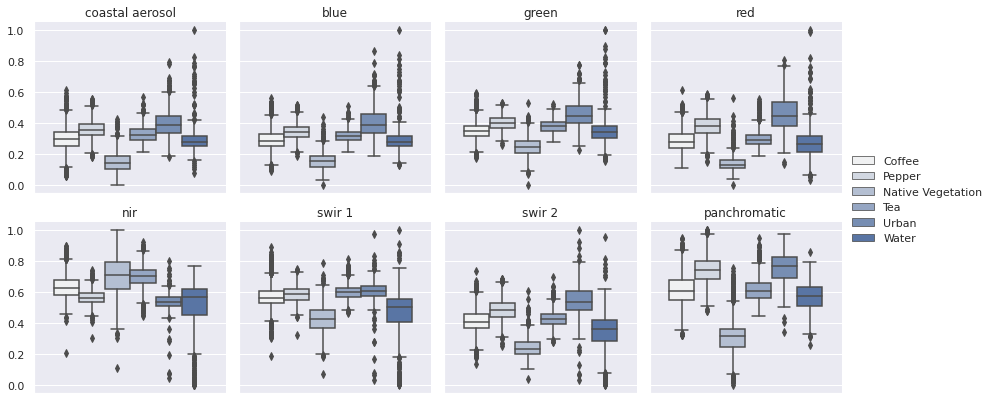

In [362]:
print(timePeriods[0])
coffee_comparison_to_other_entities('./Vietnam_01_02/merged.tif')

March - April


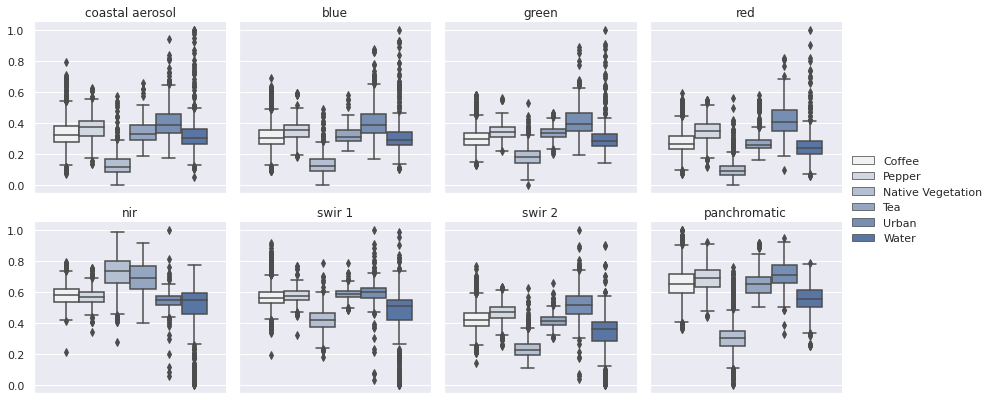

In [363]:
print(timePeriods[1])
coffee_comparison_to_other_entities('./Vietnam_03_04/merged.tif')

May - June


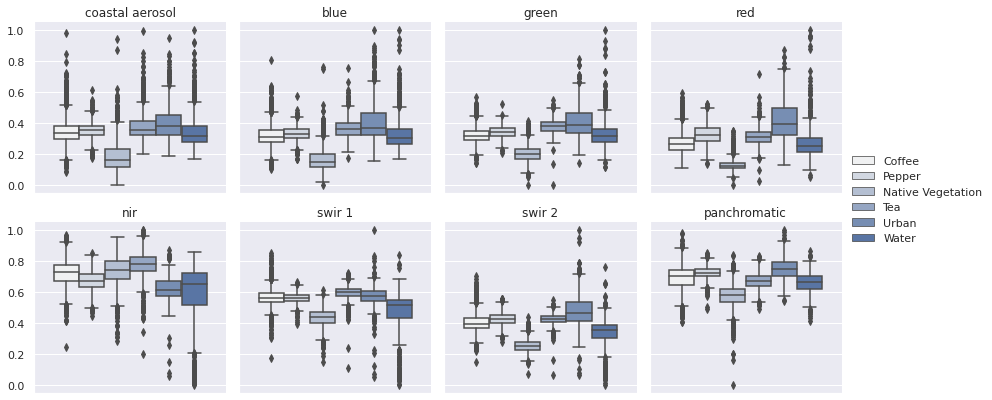

In [364]:
print(timePeriods[2])
coffee_comparison_to_other_entities('./Vietnam_05_06/merged.tif')

July - August


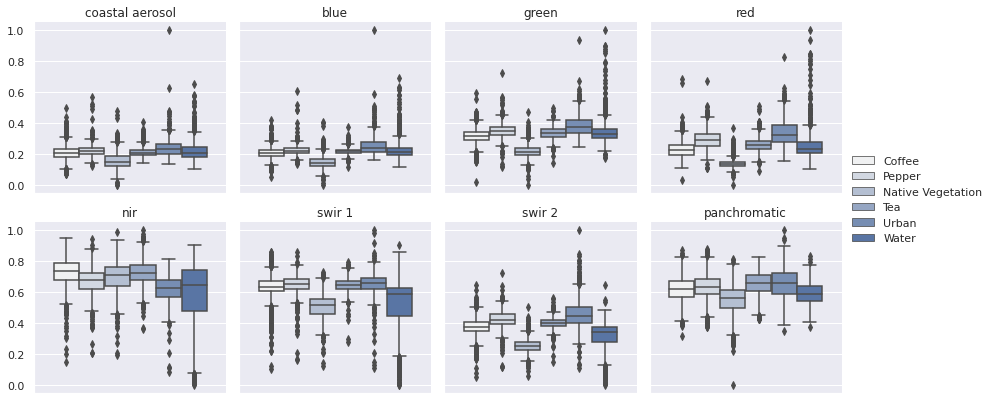

In [365]:
print(timePeriods[3])
coffee_comparison_to_other_entities('./Vietnam_07_08/merged.tif')

September - October


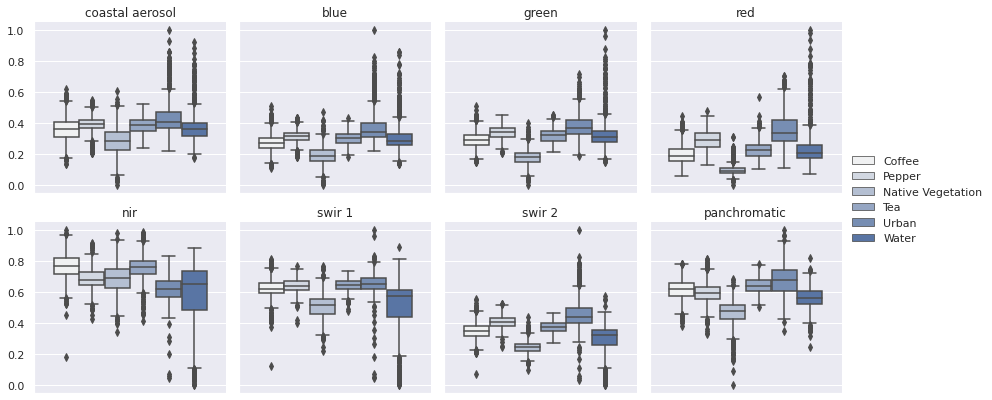

In [366]:
print(timePeriods[4])
coffee_comparison_to_other_entities('./Vietnam_09_10/merged.tif')

November - December


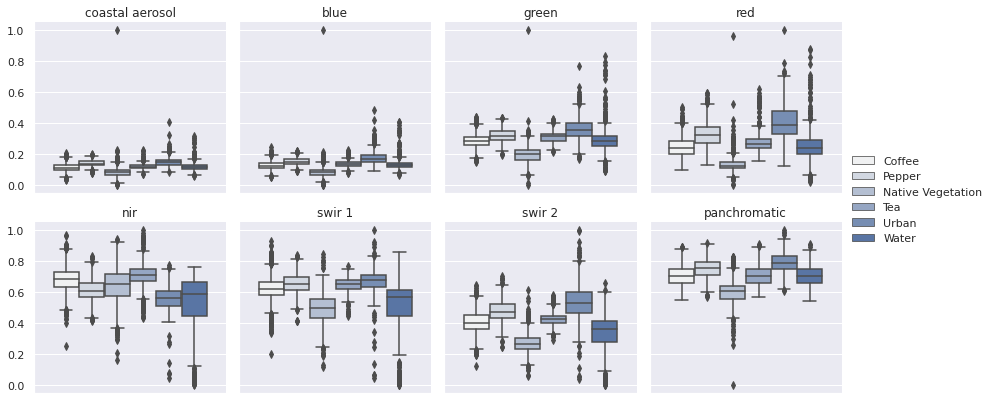

In [367]:
print(timePeriods[5])
coffee_comparison_to_other_entities('./Vietnam_11_12/merged.tif')